<b><font color="SteelBlue" size="+3">Segmentez des clients d'un site e-commerce</font></b>

# Introduction

Ce notebook la partie contrat de maintenance du projet pour OLIST.

## Imports

In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

In [3]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp

## Data

In [4]:
os.listdir()

['.ipynb_checkpoints',
 'Brazil_Regions.png',
 'carte-bresil.jpg',
 'Carte_bresil.png',
 'data',
 'Deveau_Estelle_1_script_032024.sql',
 'Deveau_Estelle_2_notebook_exploration_032024.ipynb',
 'Deveau_Estelle_3_notebook_essais_032024.ipynb',
 'Deveau_Estelle_4_notebook_simulation_032024.ipynb',
 'OC_projet5.pptx',
 'svg',
 '~$OC_projet5.pptx']

In [5]:
os.listdir("data/sources/")

['Customer.csv',
 'CustomerCategoryCounts.csv',
 'CustomerPaymentPreferences.csv',
 'periodes',
 'Script-avec-periode.sql',
 'Script_projet.sql',
 'svg_scripts']

In [6]:
os.listdir("data/sources/periodes")

['Customer', 'Payment', 'svg']

In [7]:
os.listdir("data/sources/periodes/Customer")

['Customer_170101_180101.csv',
 'Customer_170101_180115.csv',
 'Customer_170101_180201.csv',
 'Customer_170101_180215.csv',
 'Customer_170101_180301.csv',
 'Customer_170101_180315.csv',
 'Customer_170101_180401.csv',
 'Customer_170101_180415.csv',
 'Customer_170101_180501.csv',
 'Customer_170101_180515.csv',
 'Customer_170101_180601.csv',
 'Customer_170101_180615.csv',
 'Customer_170101_180701.csv',
 'Customer_170101_180715.csv',
 'Customer_170101_180801.csv']

In [8]:
os.listdir("data/sources/periodes/Payment")

['CustomerPaymentPreferences_170101_180101.csv',
 'CustomerPaymentPreferences_170101_180115.csv',
 'CustomerPaymentPreferences_170101_180201.csv',
 'CustomerPaymentPreferences_170101_180215.csv',
 'CustomerPaymentPreferences_170101_180301.csv',
 'CustomerPaymentPreferences_170101_180315.csv',
 'CustomerPaymentPreferences_170101_180401.csv',
 'CustomerPaymentPreferences_170101_180415.csv',
 'CustomerPaymentPreferences_170101_180501.csv',
 'CustomerPaymentPreferences_170101_180515.csv',
 'CustomerPaymentPreferences_170101_180601.csv',
 'CustomerPaymentPreferences_170101_180615.csv',
 'CustomerPaymentPreferences_170101_180701.csv',
 'CustomerPaymentPreferences_170101_180715.csv',
 'CustomerPaymentPreferences_170101_180801.csv']

# Liste des fichiers

In [9]:
pathCustomer = "./data/sources/periodes/Customer"
pathPayment = "./data/sources/periodes/Payment"

In [10]:
# Obtenir la liste des fichiers CSV dans chaque répertoire
data_customer = sorted([os.path.join(pathCustomer, f)
                        for f in os.listdir(pathCustomer)
                        if f.endswith('.csv')])
data_payment = sorted([os.path.join(pathPayment, f)
                       for f in os.listdir(pathPayment)
                       if f.endswith('.csv')])

# Prétraitement des données

In [11]:
def merge(df_customer, df_payment):
    """
    Fusionne deux DataFrames sur l'identifiant unique du client
    et calcule des statistiques de paiement.

    Args:
        df_customer : DataFrame contenant les informations des clients.
        df_payment : DataFrame contenant les informations
                     de paiement des clients.

    Returns:
        DataFrame: DataFrame résultant de la fusion de `df_customer`
                   avec des statistiques de paiement calculées,
                   y compris la somme totale des paiements,
                   les échéances de paiement,
                   et le pourcentage par type de paiement.

    """
    # Calculer la somme totale des paiements pour chaque client
    total_payment_by_customer = df_payment.groupby(
        'customer_unique_id')['TotalPaymentValue'].sum()

    # Calculer la somme totale des échéances de paiement pour chaque client
    total_installments_by_customer = df_payment.groupby(
        'customer_unique_id')['TotalInstallments'].sum()

    # Somme totale des paiements et des échéances de paiement
    total_by_customer = pd.concat([total_payment_by_customer,
                                   total_installments_by_customer],
                                  axis=1).reset_index()

    # Pivot pour obtenir le pourcentage par type de paiement pour chaque client
    df_payment_pivot = df_payment.pivot_table(index='customer_unique_id',
                                              columns='payment_type',
                                              values='TotalPaymentValue',
                                              aggfunc='sum',
                                              fill_value=0)

    # Calculer les pourcentages de paiement pour chaque type
    for col in df_payment_pivot.columns:
        col_pct_name = f'{col}_pct'
        df_payment_pivot[col_pct_name] = (df_payment_pivot[col]
                                          / total_by_customer.set_index(
                                              'customer_unique_id'
                                          )['TotalPaymentValue']
                                          * 100)

    # Ajouter les données totales au DataFrame pivoté
    df_payment_pivot = df_payment_pivot.merge(
        total_by_customer, on='customer_unique_id')

    # Fusionner df_customer avec les colonnes sélectionnées de df_payment_pivot
    df_merged = pd.merge(df_customer,
                         df_payment_pivot[['customer_unique_id', 'boleto_pct',
                                           'credit_card_pct', 'debit_card_pct',
                                           'voucher_pct', 'TotalPaymentValue',
                                           'TotalInstallments']],
                         on='customer_unique_id',
                         how='left')

    return df_merged

In [12]:
def nettoyage(data):
    """
    Nettoie un DataFrame en formatant les colonnes de dates et
    en supprimant les doublons.

    Cette fonction convertit les colonnes 'FirstOrderDate' et
    'LastOrderDate' en objets datetime,
    supprime les doublons basés sur 'customer_unique_id',
    ainsi que les doublons combinés de
    'FirstOrderDate', 'TotalSpent' et 'customer_city'.

    Args:
        data (DataFrame): Le DataFrame contenant les données des
        clients à nettoyer.

    Returns:
        DataFrame: Un nouveau DataFrame nettoyé, avec les dates
        formatées et sans doublons.

    """
    # Formats
    data['FirstOrderDate'] = pd.to_datetime(data['FirstOrderDate'])
    data['LastOrderDate'] = pd.to_datetime(data['LastOrderDate'])

    # doublons
    data = data.drop_duplicates(subset=["customer_unique_id"])
    data = data.drop_duplicates(subset=['FirstOrderDate',
                                        'TotalSpent', 'customer_city'])

    return data

In [13]:
def verification(data):
    """
    Vérifie la cohérence des données client en appliquant plusieurs critères.

    Cette fonction applique des vérifications sur les pourcentages de paiement
    par méthode, l'écart entre les paiements et la somme des dépenses et frais
    de port, les notes d'avis, le nombre de commentaires et de titres de
    commentaires par rapport aux avis, et la catégorisation
    des dépenses. Elle corrige ou élimine les données incohérentes.

    Args:
        data (DataFrame): Le DataFrame des données clients à vérifier.

    Returns:
        DataFrame: Le DataFrame nettoyé après vérification et correction des
        données incohérentes.

    """
    tolerance = 0.1
    data = data.copy()

    # Vérifier que la somme des pourcentages des sommes dépensées
    # dans chaque catégorie est proche de 100%
    data = data[(abs(data['boleto_pct']
                     + data['credit_card_pct']
                     + data['debit_card_pct']
                     + data['voucher_pct']
                     - 100) <= tolerance)]

    # Vérifier la cohérence entre la valeur totale des paiements
    # et la somme de TotalSpent + TotalFreight
    data['payment_difference'] = abs(data['TotalPaymentValue']
                                     - (data['TotalSpent']
                                        + data['TotalFreight']))
    data = data[data['payment_difference'] <= (data['TotalPaymentValue']
                                               * tolerance)]

    # Supprimer les lignes où 'AverageReviewScore'
    # n'est pas compris entre 0 et 5
    data = data.query(
        "AverageReviewScore.isna() or "
        "(AverageReviewScore >= 0 and AverageReviewScore <= 5)")

    # Supprimer les lignes où 'NumberOfComments' ou 'NumberOfCommentTitles'
    # est supérieur à 'NumberOfReviews'
    data = data.query("NumberOfComments <= NumberOfReviews and "
                      "NumberOfCommentTitles <= NumberOfReviews")

    # Remplacer les valeurs de 'DifferentCategories' égales à 0 par 1
    data.loc[data['DifferentCategories'] == 0, 'DifferentCategories'] = 1

    # Suppression des colonnes qui servaient à la verification des données
    data = data.drop(columns=['TotalPaymentValue'])

    return data

In [14]:
def completion(data):
    """
    Complète les données en supprimant les lignes où des valeurs spécifiques
    sont manquantes.

    Cette fonction élimine les enregistrements du DataFrame où la valeur de
    'AvgWeight' est manquante. Ce processus permet de s'assurer que les
    analyses ultérieures sur le poids moyen se basent sur des données complètes

    Args:
        data (DataFrame): Le DataFrame contenant les données clients qui
        nécessitent une complétion.

    Returns:
        DataFrame: Le DataFrame après suppression des lignes avec des valeurs
        manquantes pour 'AvgWeight'.
    """
    # Supprimer les lignes où la colonne 'AvgWeight' est NaN
    data = data.dropna(subset=['AvgWeight'])

    return data

In [15]:
def featuring(df, featureslist):
    """
    Génère de nouvelles features basées sur les données existantes pour
    préparer une analyse de clustering.

    Cette fonction crée de nouvelles colonnes basées sur des calculs de
    recency, frequency, montant moyen (panier moyen) et un indice d'engagement
    basé sur les activités de commentaires des clients. Ces features sont
    ajoutées au DataFrame pour enrichir les données avant une segmentation de
    clientèle.

    Args:
        df (DataFrame): Le DataFrame contenant les données d'achat et de
                        comportement des clients.
        featureslist (list): Une liste des noms des nouvelles features à
                             inclure dans le DataFrame résultant.

    Returns:
        DataFrame: Un DataFrame avec les nouvelles features ajoutées selon
        `featureslist`.
    """
    df = df.copy()

    # Recence
    reference_date = df['LastOrderDate'].max()
    df['Recency'] = (reference_date - df['LastOrderDate']).dt.days

    # Frequence
    df['Frequency'] = df['TotalOrders']

    # Montant (= panier moyen)
    df['TotalAmount'] = df['TotalSpent'] + df['TotalFreight']
    df['AvgBasket'] = df['TotalAmount']/df['TotalOrders']

    # Calcul de l'indice d'engagement en fonction des commentaires
    df['EngagementIndex'] = (0.5 * df['NumberOfReviews']
                             + 0.25 * df['NumberOfCommentTitles']
                             + 0.25 * df['NumberOfComments']) / (df['nb_item'])

    df = df[['customer_unique_id'] + featureslist]

    return df

In [16]:
standard_scaler = StandardScaler()


def scale(data):
    """
    Normalise les features numériques d'un DataFrame en utilisant le
    StandardScaler.

    Cette fonction prend un DataFrame où chaque ligne représente un client
    et chaque colonne une feature numérique à normaliser.

    Args:
        data (DataFrame): Le DataFrame contenant les features à normaliser.

    Returns:
        DataFrame: Un DataFrame où les valeurs des features ont été normalisées
    """
    # Définir 'customer_unique_id' comme l'index du DataFrame
    data = data.set_index('customer_unique_id')

    scaled_data = pd.DataFrame(standard_scaler.fit_transform(data),
                               index=data.index,
                               columns=data.columns)

    return scaled_data

In [17]:
def traitement(file_cutomer, file_payment, featureslist):
    """
    Applique une série de traitements de préparation des données pour
    le clustering.
    fusion, nettoyage, vérification, complétion, mise en forme des features
    et normalisation.

    Args:
        file_customer (str): Chemin du fichier CSV des clients.
        file_payment (str): Chemin du fichier CSV des paiements.
        featureslist (list): Features à conserver.

    Returns:
        DataFrame: Données prêtes pour le clustering.
    """
    df_merged = merge(file_cutomer, file_payment)
    df_cleaned = nettoyage(df_merged)
    df_verified = verification(df_cleaned)
    df_completed = completion(df_verified)
    df_featured = featuring(df_completed, featureslist)
    df_scaled = scale(df_featured)

    return df_scaled

In [18]:
def traitement_noscale(file_cutomer, file_payment, featureslist):
    """
    Applique une série de traitements de préparation des données pour
    le clustering.
    fusion, nettoyage, vérification, complétion, mise en forme des features

    Args:
        file_customer (str): Chemin du fichier CSV des clients.
        file_payment (str): Chemin du fichier CSV des paiements.
        featureslist (list): Features à conserver.

    Returns:
        DataFrame: Données prêtes pour le clustering.
    """
    df_merged = merge(file_cutomer, file_payment)
    df_cleaned = nettoyage(df_merged)
    df_verified = verification(df_cleaned)
    df_completed = completion(df_verified)
    df_featured = featuring(df_completed, featureslist)

    return df_featured

# Détermination de la période de réentrainement conseillée

## ARI et KS

In [19]:
# Calcul ARI
def ari_calc(customer_files, payment_files, nbclusters, featurelist):
    """
    Calcule l'Adjusted Rand Index (ARI) pour évaluer la stabilité du clustering

    Args:
        customer_files (list): Liste des chemins vers les fichiers clients.
        payment_files (list): Liste des chemins vers les fichiers paiements.
        nbclusters (int): Nombre de clusters à utiliser pour KMeans.
        featurelist (list): Liste des caractéristiques à utiliser pour le
                            clustering.

    Returns:
        list: Scores ARI pour chaque période.
    """
    ari_scores = []

    # Initialiser KMeans une seule fois avec le nombre de clusters déterminé
    kmeans = KMeans(n_clusters=nbclusters, random_state=42, n_init=10)
    customer_labels_first_period = {}

    for i, (file_customer, file_payment) in enumerate(zip(customer_files,
                                                          payment_files)):
        # Charger les fichiers CSV
        df_customer = pd.read_csv(file_customer)
        df_payment = pd.read_csv(file_payment)

        # Prétraitement
        data = traitement(df_customer,
                          df_payment, features)

        if i == 0:
            # Entraîner KMeans sur la première période
            kmeans.fit(data[featurelist])
            # identifiant des client p1
            customer_ids_first_period = set(data.index)
            # Stockage des labels de la première période
            customer_labels_first_period = {idx: lbl
                                            for idx, lbl
                                            in zip(data.index, kmeans.labels_)}
            ari_scores.append(1.0)
        else:
            # Filtrer pour ne garder que les clients présents
            # lors de la première période
            data_common = data.loc[data.index.isin(
                customer_ids_first_period)].copy()
            # prediction
            predicted_clusters = kmeans.predict(data_common[featurelist])
            # Filtrer labels_de_reference pour ne garder
            # que ceux correspondant aux clients communs
            labels_de_reference = [customer_labels_first_period[idx]
                                   for idx in data_common.index
                                   if idx in customer_labels_first_period]
            # Calcul de l'ARI
            ari = adjusted_rand_score(labels_de_reference, predicted_clusters)
            ari_scores.append(ari)

    return ari_scores

In [20]:
# Test de KS
def ks_analysis_between_periods(file_customer_ref,
                                file_payment_ref,
                                file_customer_current,
                                file_payment_current, features):
    """
    Compare les distributions des caractéristiques des clients entre
    la période de référence et une nouvelle période donnée en utilisant
    le test de Kolmogorov-Smirnov.

    Args:
        file_customer_previous (str): Chemin vers le fichier CSV des clients
                                      pour la période de référence.
        file_payment_previous (str): Chemin vers le fichier CSV des paiements
                                    pour la période de référence.
        file_customer_current (str): Chemin vers le fichier CSV des clients
                                     pour la période actuelle.
        file_payment_current (str): Chemin vers le fichier CSV des paiements
                                    pour la période actuelle.
        features (list): Liste des caractéristiques à analyser.

    Returns:
        dict: Dictionnaire contenant les résultats du test KS, incluant la
        statistique de test et la p-value pour chaque caractéristique analysée.
    """
    # Charger les données pour les deux périodes
    df_customer_ref = pd.read_csv(file_customer_ref)
    df_payment_ref = pd.read_csv(file_payment_ref)
    data_ref = traitement(df_customer_ref,
                          df_payment_ref,
                          features)

    df_customer_current = pd.read_csv(file_customer_current)
    df_payment_current = pd.read_csv(file_payment_current)
    data_current = traitement(df_customer_current,
                              df_payment_current,
                              features)

    # Initialiser un dictionnaire pour stocker les résultats du test KS
    ks_results = {}

    # Exécuter le test KS pour chaque feature
    for feature in features:
        sample_ref = data_ref[feature].dropna()
        sample_new = data_current[feature].dropna()
        ks_statistic, p_value = ks_2samp(sample_ref, sample_new)
        ks_results[feature] = {'ks_statistic': ks_statistic,
                               'p_value': p_value}

    return ks_results

### 12 indicateurs

In [21]:
# liste des features
features = ['Recency', 'Frequency', 'AvgBasket', 'nb_item',
            'AverageReviewScore', 'EngagementIndex', 'DeliveryDelay',
            'AvgWeight', 'TotalInstallments', 'ActualDeliveryTime',
            'boleto_pct', 'voucher_pct']

#### ARI

In [22]:
ari_scores = ari_calc(data_customer, data_payment, 12, features)
ari_scores

[1.0,
 0.948096511991848,
 0.8895324023843055,
 0.8542476927979371,
 0.8093342333747267,
 0.763896261729035,
 0.7150497678496066,
 0.6886152837133425,
 0.665310866314249,
 0.6420997373847995,
 0.6249300387918112,
 0.6119066167885442,
 0.6006635592539947,
 0.5927623729482271,
 0.5786769588589482]

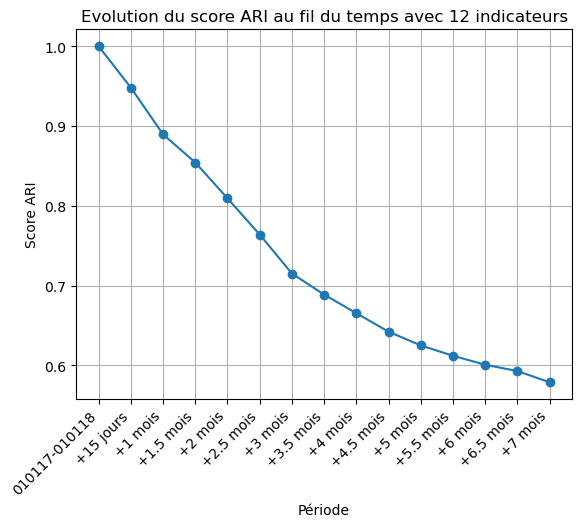

In [23]:
# Définition des noms des périodes
period_names = [
    '010117-010118', '+15 jours', '+1 mois',
    '+1.5 mois', '+2 mois', '+2.5 mois',
    '+3 mois', '+3.5 mois', '+4 mois',
    '+4.5 mois', '+5 mois', '+5.5 mois',
    '+6 mois', '+6.5 mois', '+7 mois'
]

# Affichage de la courbe ARI
plt.plot(ari_scores, marker='o', linestyle='-')
plt.title('Evolution du score ARI au fil du temps avec 12 indicateurs')
plt.xlabel('Période')
plt.ylabel('Score ARI')
plt.xticks(range(len(ari_scores)), period_names,
           rotation=45, ha='right')
plt.grid(True)
plt.show()

#### Kolmogorov-Smirnov

In [24]:
ks_results_all_periods = []
for i in range(1, len(data_customer)):
    ks_results = ks_analysis_between_periods(data_customer[0],
                                             data_payment[0],
                                             data_customer[i],
                                             data_payment[i],
                                             features)
    ks_results_all_periods.append(ks_results)

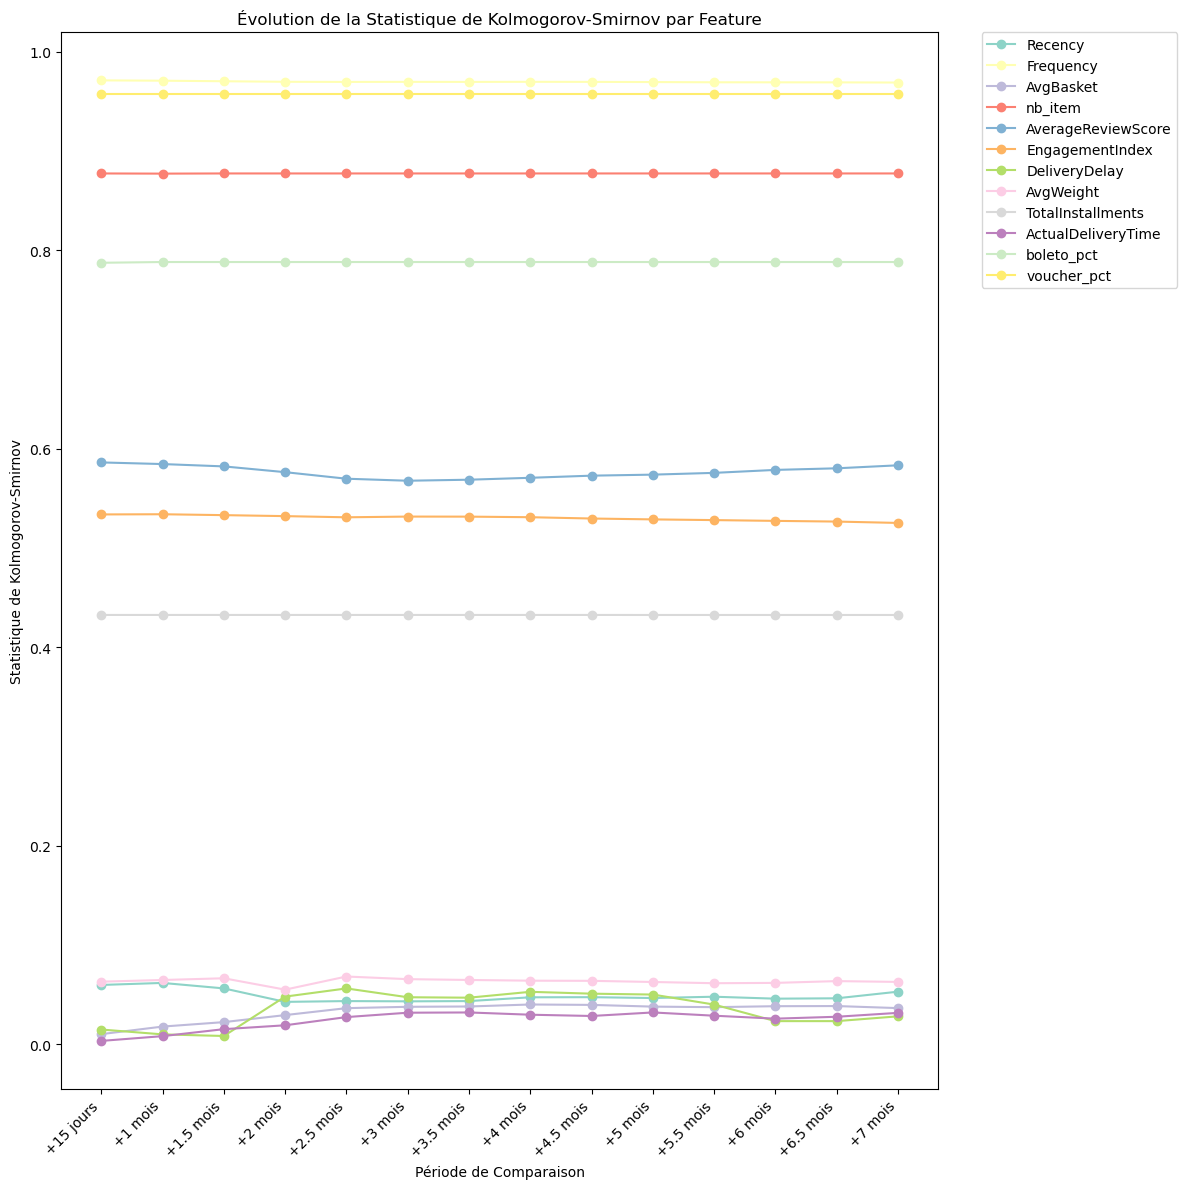

In [25]:
# Exclure le premier nom de la liste pour les étiquettes des ticks
period_names_adjusted = period_names[1:]
# Affichage de l'evolution KS
plt.figure(figsize=(12, 12))

# Nombre de périodes à comparer (nombre de tests KS réalisés)
n_periods = len(ks_results_all_periods)

palette = sns.color_palette('Set3', n_colors=len(features))

# Pour chaque feature, tracer les statistiques KS
for i, feature in enumerate(features):
    ks_statistics = [result[feature]['ks_statistic']
                     for result in ks_results_all_periods]
    plt.plot(range(n_periods), ks_statistics,
             marker='o', linestyle='-',
             label=feature, color=palette[i])

plt.xticks(range(n_periods), period_names_adjusted,
           rotation=45, ha='right')
plt.xlabel('Période de Comparaison')
plt.ylabel('Statistique de Kolmogorov-Smirnov')
plt.title('Évolution de la Statistique de Kolmogorov-Smirnov par Feature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

### 9 indicateurs

In [26]:
# liste des features
features9 = ['Recency', 'Frequency', 'AvgBasket', 'nb_item',
             'AverageReviewScore', 'EngagementIndex', 'DeliveryDelay',
             'boleto_pct', 'voucher_pct']

#### ARI

In [27]:
ari_scores = ari_calc(data_customer, data_payment, 12, features9)
ari_scores

[1.0,
 0.9420503032737811,
 0.8807022345261986,
 0.8388556648173933,
 0.7893320956184138,
 0.7401911263003161,
 0.6852847530004492,
 0.6562935000132163,
 0.6293980243375822,
 0.6052670566922422,
 0.5873529354111591,
 0.5738999459225258,
 0.559981326339682,
 0.5517827450212225,
 0.5414165950201779]

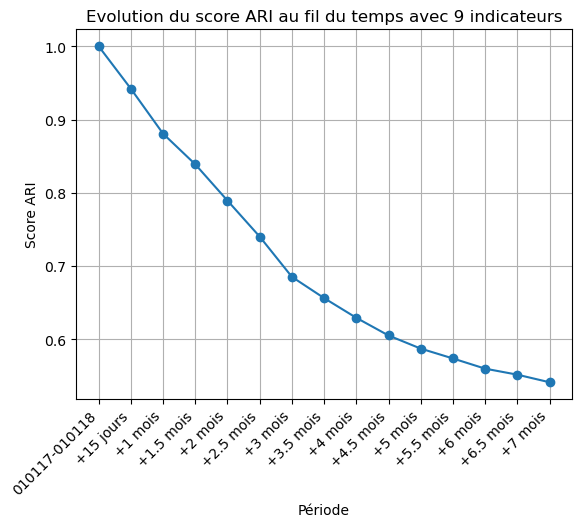

In [28]:
# Affichage de la courbe ARI
plt.plot(ari_scores, marker='o', linestyle='-')
plt.title('Evolution du score ARI au fil du temps avec 9 indicateurs')
plt.xlabel('Période')
plt.ylabel('Score ARI')
plt.xticks(range(len(ari_scores)), period_names,
           rotation=45, ha='right')
plt.grid(True)
plt.show()

#### Kolmogorov-Smirnov

In [29]:
ks_results_all_periods = []
for i in range(1, len(data_customer)):
    ks_results = ks_analysis_between_periods(data_customer[0],
                                             data_payment[0],
                                             data_customer[i],
                                             data_payment[i],
                                             features)
    ks_results_all_periods.append(ks_results)

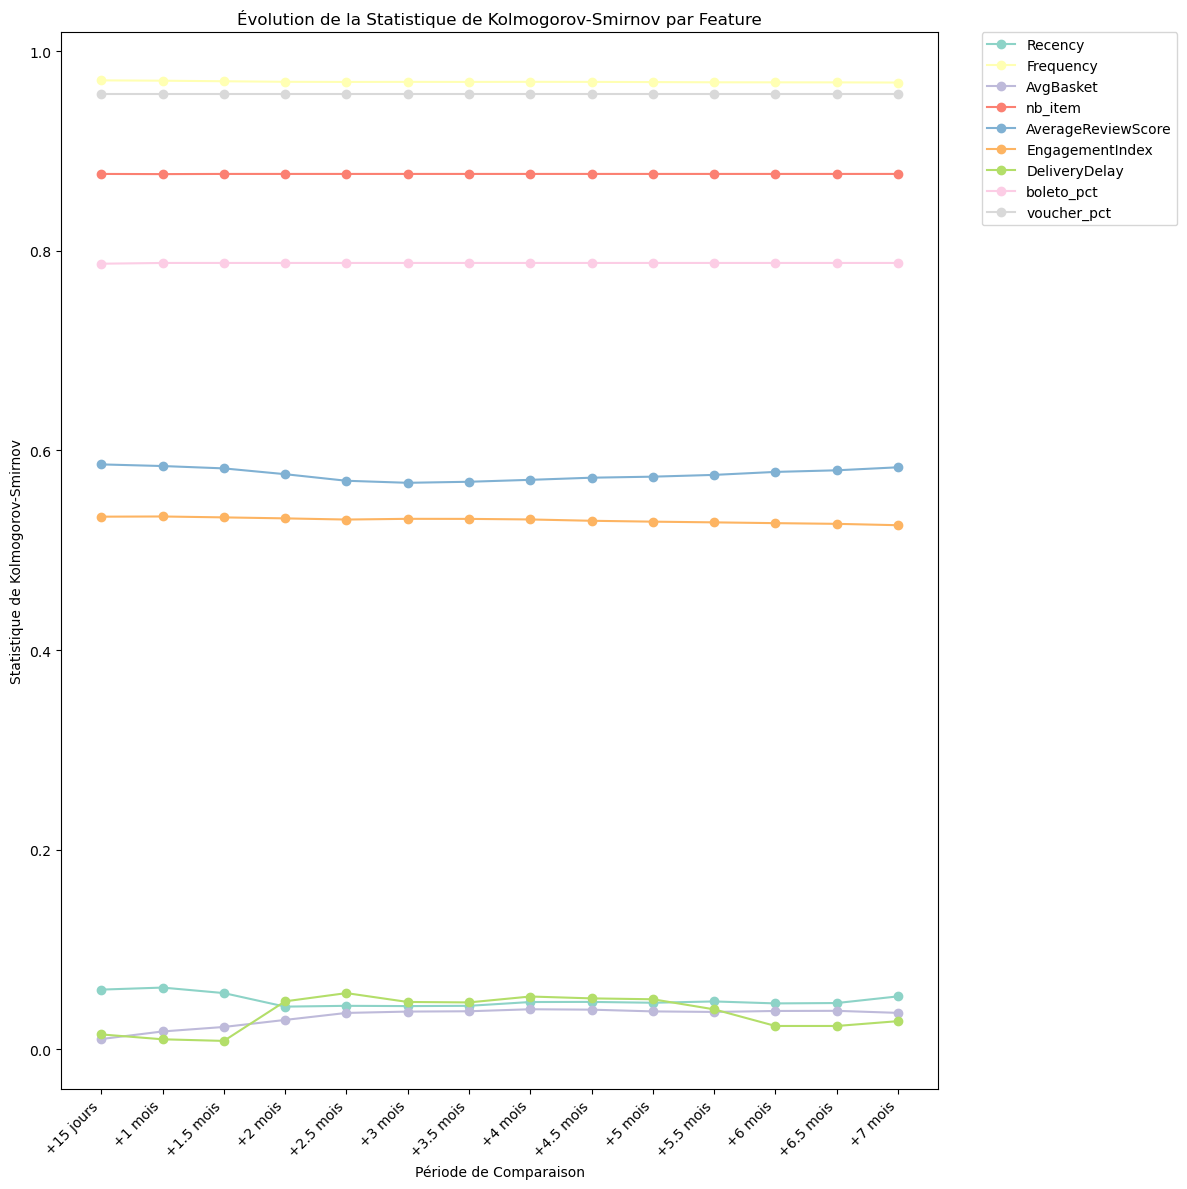

In [30]:
# Affichage de l'evolution KS
plt.figure(figsize=(12, 12))

# Nombre de périodes à comparer (nombre de tests KS réalisés)
n_periods = len(ks_results_all_periods)

palette = sns.color_palette('Set3', n_colors=len(features9))

# Pour chaque feature, tracer les statistiques KS
for i, feature in enumerate(features9):
    ks_statistics = [result[feature]['ks_statistic']
                     for result in ks_results_all_periods]
    plt.plot(range(n_periods), ks_statistics,
             marker='o', linestyle='-',
             label=feature, color=palette[i])

plt.xticks(range(n_periods), period_names_adjusted,
           rotation=45, ha='right')
plt.xlabel('Période de Comparaison')
plt.ylabel('Statistique de Kolmogorov-Smirnov')
plt.title('Évolution de la Statistique de Kolmogorov-Smirnov par Feature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

### 7 indicateurs

In [31]:
# liste des features
features7 = ['Recency', 'Frequency', 'AvgBasket', 'nb_item',
             'AverageReviewScore', 'EngagementIndex', 'DeliveryDelay']

#### ARI

In [32]:
ari_scores = ari_calc(data_customer, data_payment, 9, features7)
ari_scores

[1.0,
 0.9474181342803109,
 0.8793057236943966,
 0.8296714615903195,
 0.7715429141428063,
 0.7242211159226349,
 0.6719946471039656,
 0.6306548388410942,
 0.5742375187156933,
 0.5213473971502675,
 0.49026713289062956,
 0.4688191393909934,
 0.44436839203137257,
 0.42734008123077416,
 0.3966156384404805]

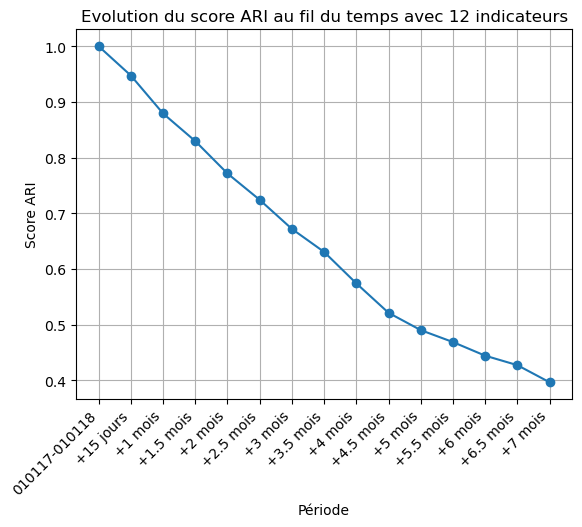

In [33]:
# Affichage de la courbe ARI
plt.plot(ari_scores, marker='o', linestyle='-')
plt.title('Evolution du score ARI au fil du temps avec 12 indicateurs')
plt.xlabel('Période')
plt.ylabel('Score ARI')
plt.xticks(range(len(ari_scores)), period_names,
           rotation=45, ha='right')
plt.grid(True)
plt.show()

#### Kolmogorov-Smirnov

In [34]:
ks_results_all_periods = []
for i in range(1, len(data_customer)):
    ks_results = ks_analysis_between_periods(data_customer[0],
                                             data_payment[0],
                                             data_customer[i],
                                             data_payment[i],
                                             features)
    ks_results_all_periods.append(ks_results)

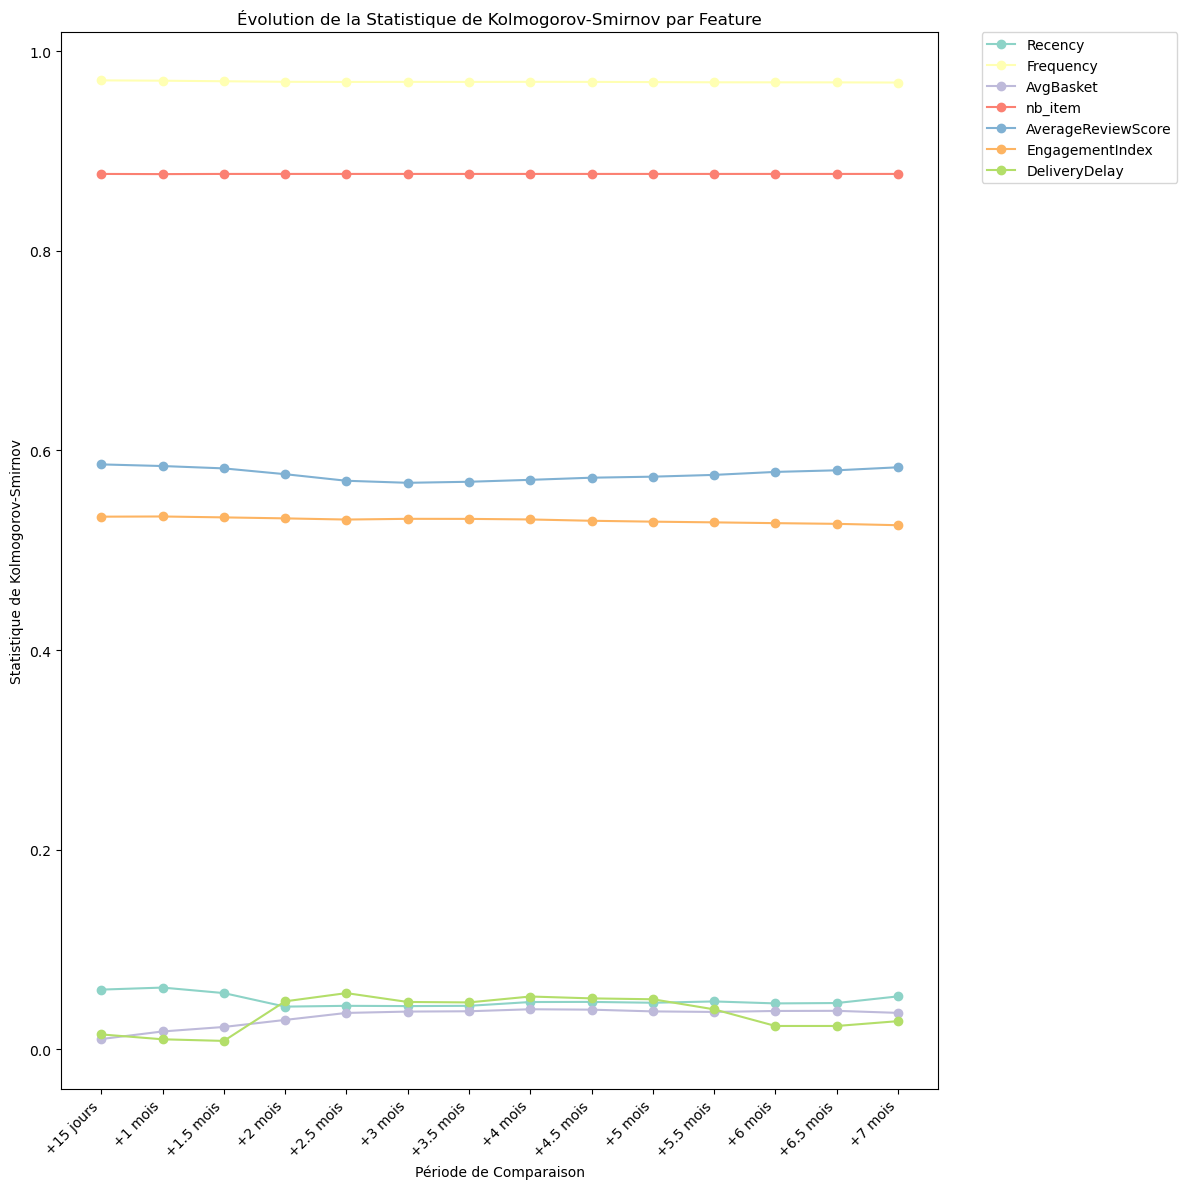

In [35]:
# Affichage de l'evolution KS
plt.figure(figsize=(12, 12))

# Nombre de périodes à comparer (nombre de tests KS réalisés)
n_periods = len(ks_results_all_periods)

palette = sns.color_palette('Set3', n_colors=len(features7))

# Pour chaque feature, tracer les statistiques KS
for i, feature in enumerate(features7):
    ks_statistics = [result[feature]['ks_statistic']
                     for result in ks_results_all_periods]
    plt.plot(range(n_periods), ks_statistics,
             marker='o', linestyle='-',
             label=feature, color=palette[i])

plt.xticks(range(n_periods), period_names_adjusted,
           rotation=45, ha='right')
plt.xlabel('Période de Comparaison')
plt.ylabel('Statistique de Kolmogorov-Smirnov')
plt.title('Évolution de la Statistique de Kolmogorov-Smirnov par Feature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## Graphiques d'évolution

### Distributions

In [36]:
# Graph de distribution
def graphDistri(customer_files, payment_files, featurelist):
    """
    Affiche des graphiques de distribution pour chaque caractéristique
    spécifiée à travers différentes périodes.

    Args:
        customer_files (list): Liste des chemins vers les fichiers CSV des
                               clients pour chaque période.
        payment_files (list): Liste des chemins vers les fichiers CSV des
                              paiements pour chaque période.
        features (list): Liste des caractéristiques pour lesquelles afficher
                         les distributions.

    Cette fonction charge les données des fichiers spécifiés, applique un
    prétraitement sans mise à l'échelle, ajoute une colonne indiquant la
    période correspondante, et concatène toutes les données dans un DataFrame
    unique. Ensuite, pour chaque caractéristique spécifiée, elle affiche un
    ensemble de graphiques de distribution, un pour chaque période.
    """
    allData = pd.DataFrame()
    for i, (file_customer, file_payment) in enumerate(zip(customer_files,
                                                          payment_files)):
        # Charger les fichiers CSV
        df_customer = pd.read_csv(file_customer)
        df_payment = pd.read_csv(file_payment)

        # Prétraitement
        data = traitement_noscale(df_customer,
                                  df_payment, features)

        # Ajout de la colonne periode
        data['Periode'] = i

        # Ajout des données au df général
        allData = pd.concat([allData, data])

    for feature in features:
        g = sns.FacetGrid(allData, col='Periode', col_wrap=15, height=3)
        g = g.map(sns.histplot, feature, kde=False)
    plt.show()

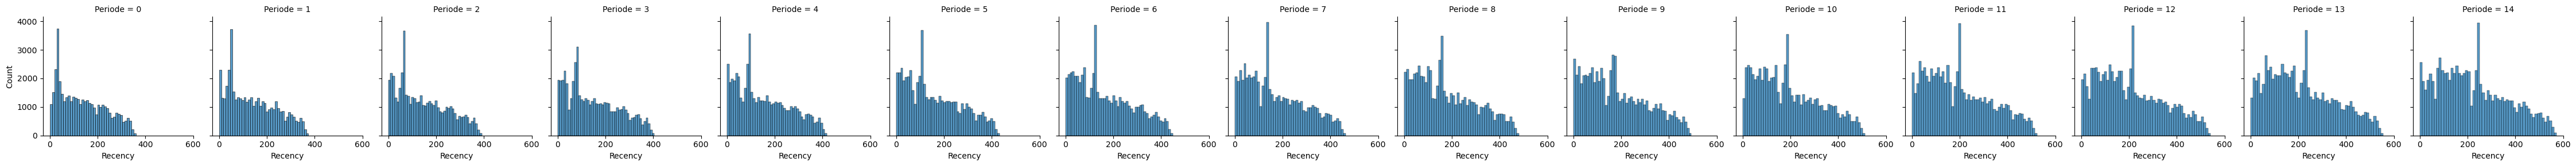

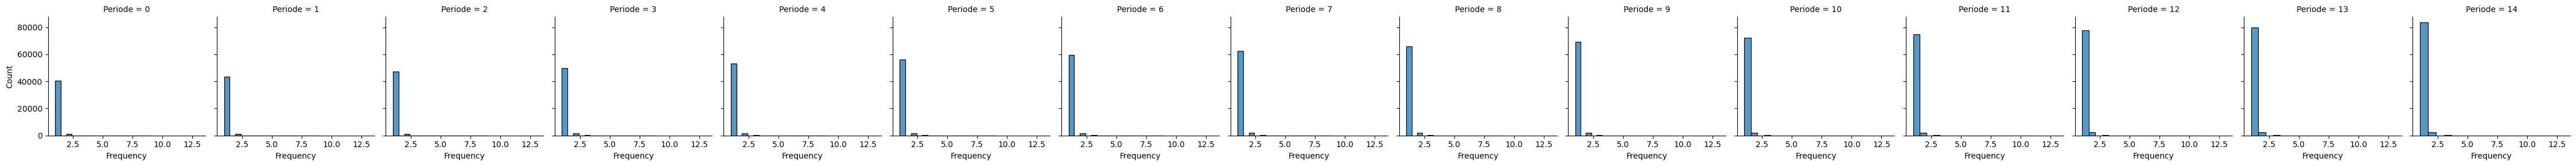

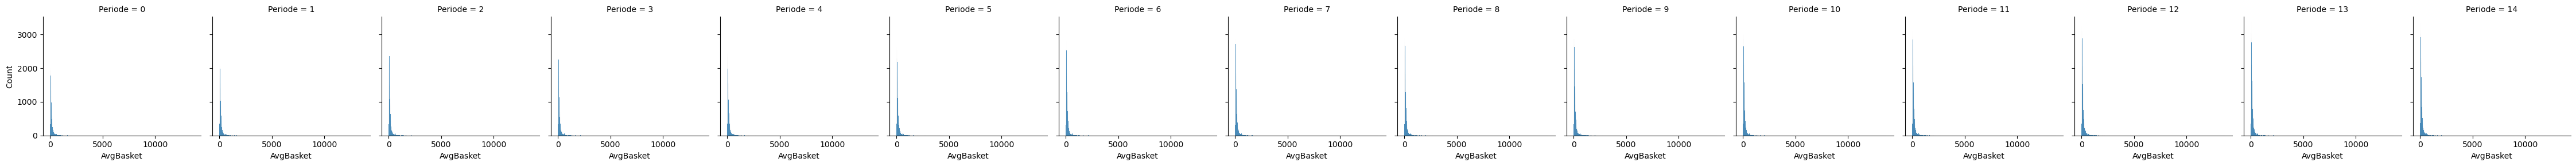

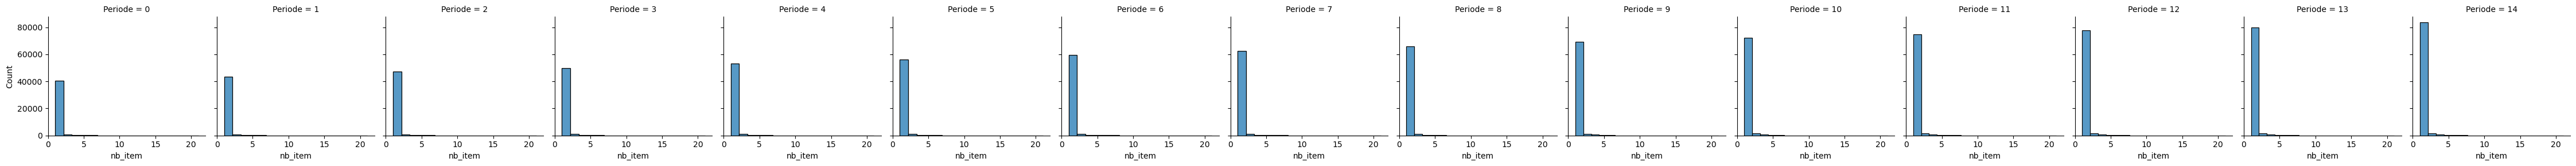

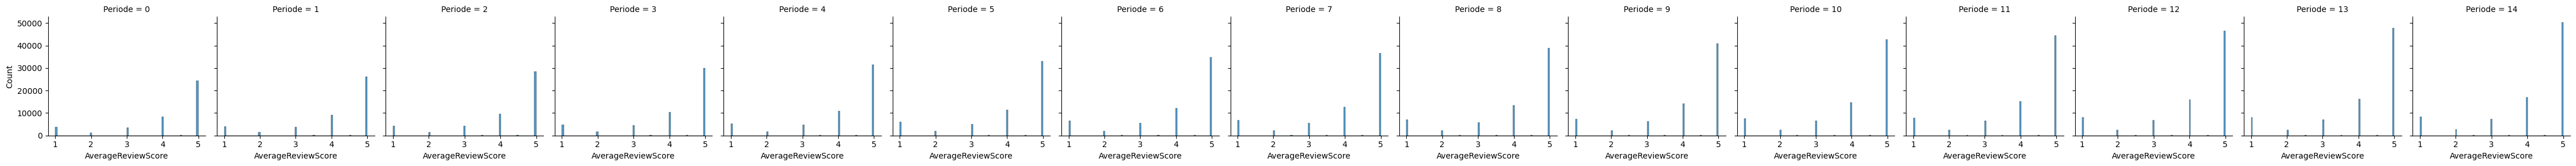

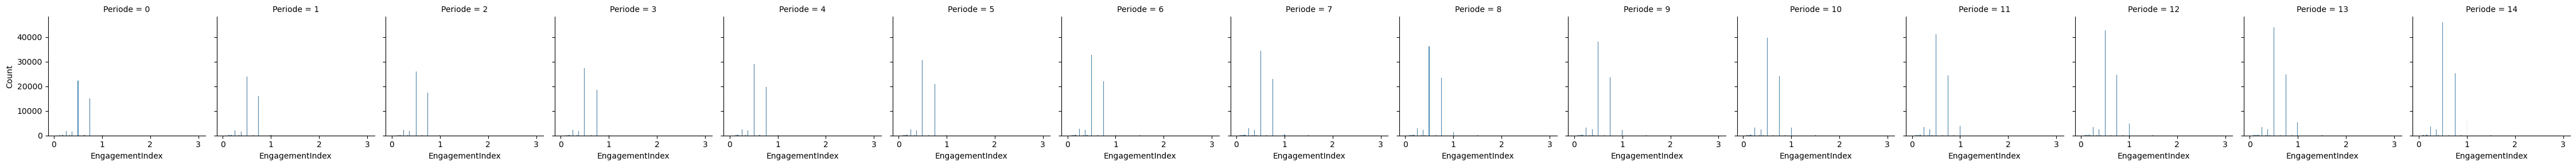

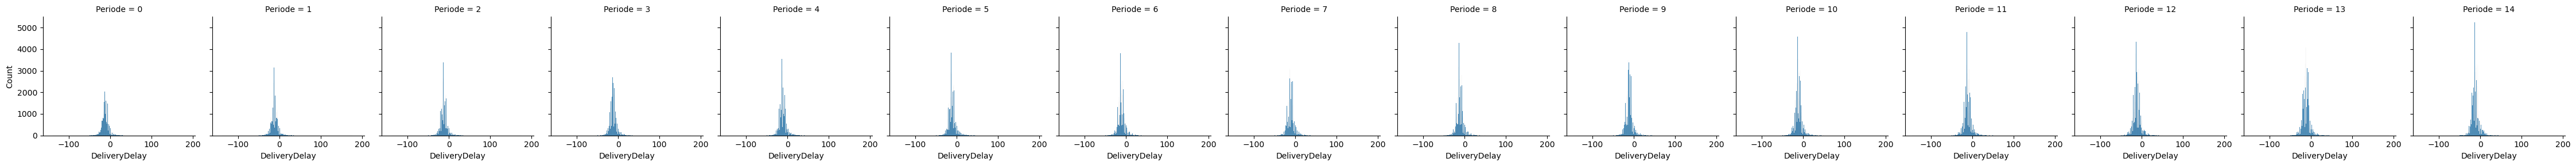

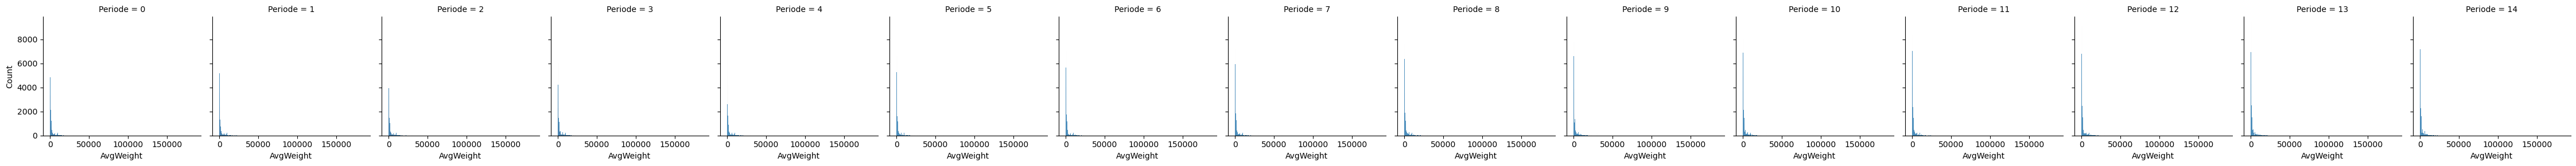

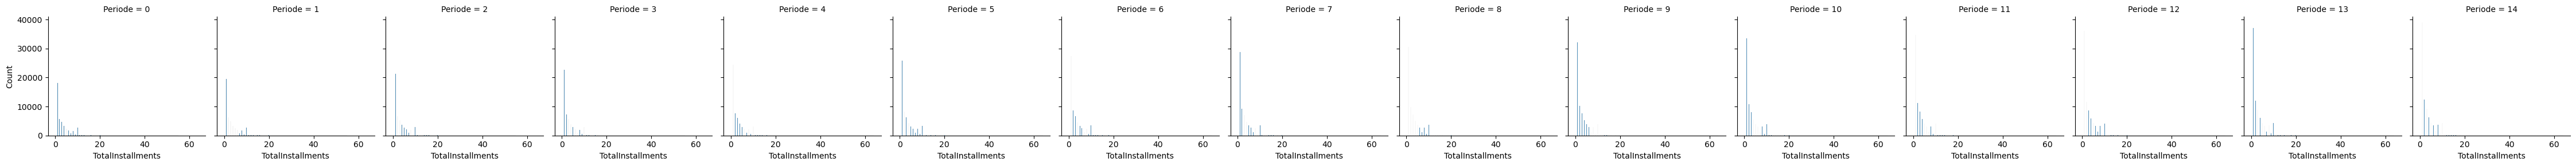

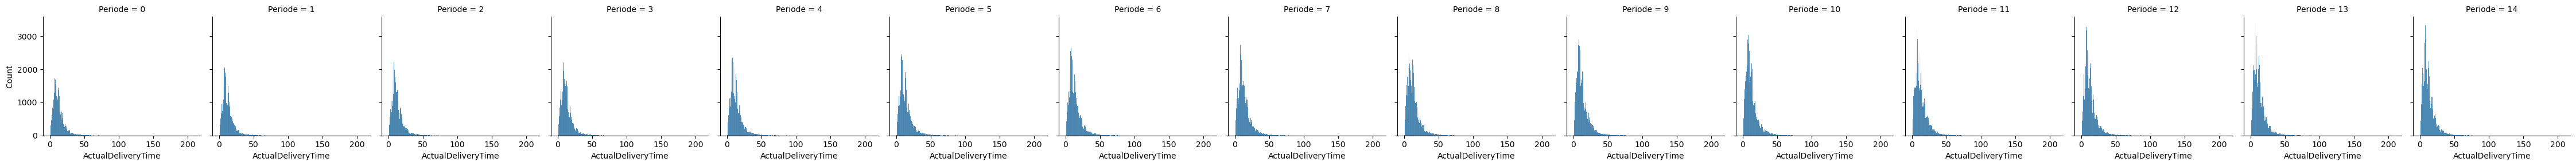

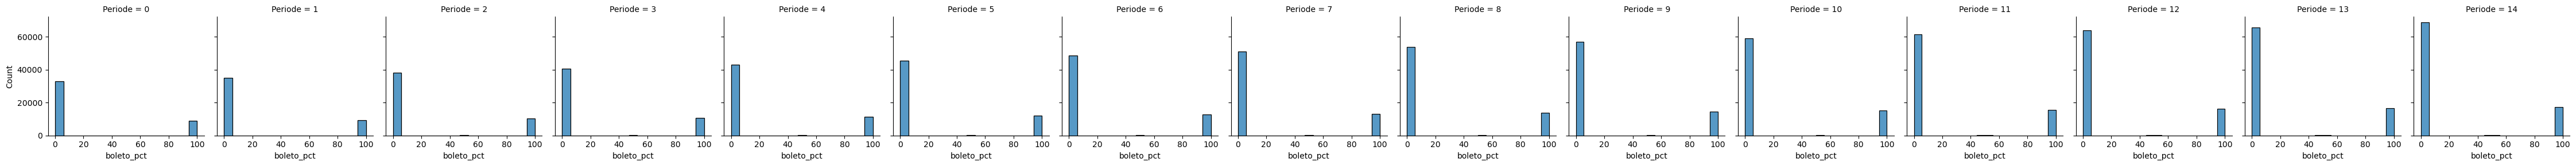

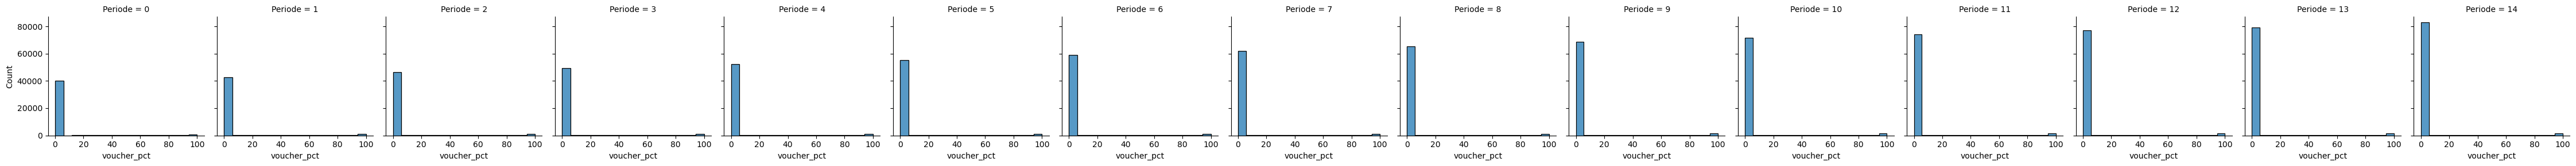

In [37]:
graphDistri(data_customer, data_payment, features)

### Graphique de série Temporelle

In [38]:
def graphStatsTimeSeries(customer_files, payment_files, features):
    """
    Trace des graphiques de séries temporelles pour les statistiques
    (moyenne, médiane, écart-type) de chaque caractéristique spécifiée
    à travers différentes périodes.

    Args:
        customer_files (list): Liste des chemins vers les fichiers CSV des
        clients pour chaque période.
        payment_files (list): Liste des chemins vers les fichiers CSV des
        paiements pour chaque période.
        features (list): Liste des caractéristiques pour lesquelles tracer
        les séries temporelles.

    Cette fonction charge et prétraite les données des clients et des paiements
    pour chaque période spécifiée.
    Elle calcule ensuite la moyenne, la médiane et l'écart-type pour chaque
    caractéristique et période, et trace
    des graphiques de séries temporelles montrant l'évolution de ces
    statistiques au fil du temps.
    """
    stats_over_time = {'Periode': [], 'Moyenne': {},
                       'Mediane': {}, 'EcartType': {}}

    for i, (file_customer, file_payment) in enumerate(zip(customer_files,
                                                          payment_files)):
        # Charger les fichiers CSV
        df_customer = pd.read_csv(file_customer)
        df_payment = pd.read_csv(file_payment)

        # Prétraitement
        data = traitement_noscale(df_customer, df_payment, features)

        # Ajout de la colonne periode
        periode_label = f'Periode {i}'

        # calcul des stats
        stats_over_time['Periode'].append(periode_label)
        for feature in features:
            if feature not in stats_over_time['Moyenne']:
                stats_over_time['Moyenne'][feature] = []
                stats_over_time['Mediane'][feature] = []
                stats_over_time['EcartType'][feature] = []

            stats_over_time['Moyenne'][feature].append(data[feature].mean())
            stats_over_time['Mediane'][feature].append(data[feature].median())
            stats_over_time['EcartType'][feature].append(data[feature].std())

    # Affichage des graphiques
    fig, axs = plt.subplots(3, 4, figsize=(30, 20))
    axs = axs.ravel()
    for idx, feature in enumerate(features):
        # Placer les données sur le subplot correspondant
        ax = axs[idx % 12]  # 12 subplots au total
        ax.plot(stats_over_time['Periode'],
                stats_over_time['Moyenne'][feature],
                marker='o', label='Moyenne')
        ax.plot(stats_over_time['Periode'],
                stats_over_time['Mediane'][feature],
                marker='s', label='Mediane')
        ax.plot(stats_over_time['Periode'],
                stats_over_time['EcartType'][feature],
                marker='^', label='EcartType')

        # Réglage de l'échelle y pour chaque feature
        all_values = (stats_over_time['Moyenne'][feature]
                      + stats_over_time['Mediane'][feature]
                      + stats_over_time['EcartType'][feature])
        ymin, ymax = min(all_values), max(all_values)
        marge = (ymax - ymin) * 0.1
        ax.set_ylim(ymin - marge, ymax + marge)

        ax.set_title(f'Evolution de {feature}')
        ax.set_ylabel('Valeur')
        ax.set_xlabel('Période')
        ax.tick_params(axis='x', labelrotation=45)
        ax.legend()

    plt.tight_layout()
    plt.show()

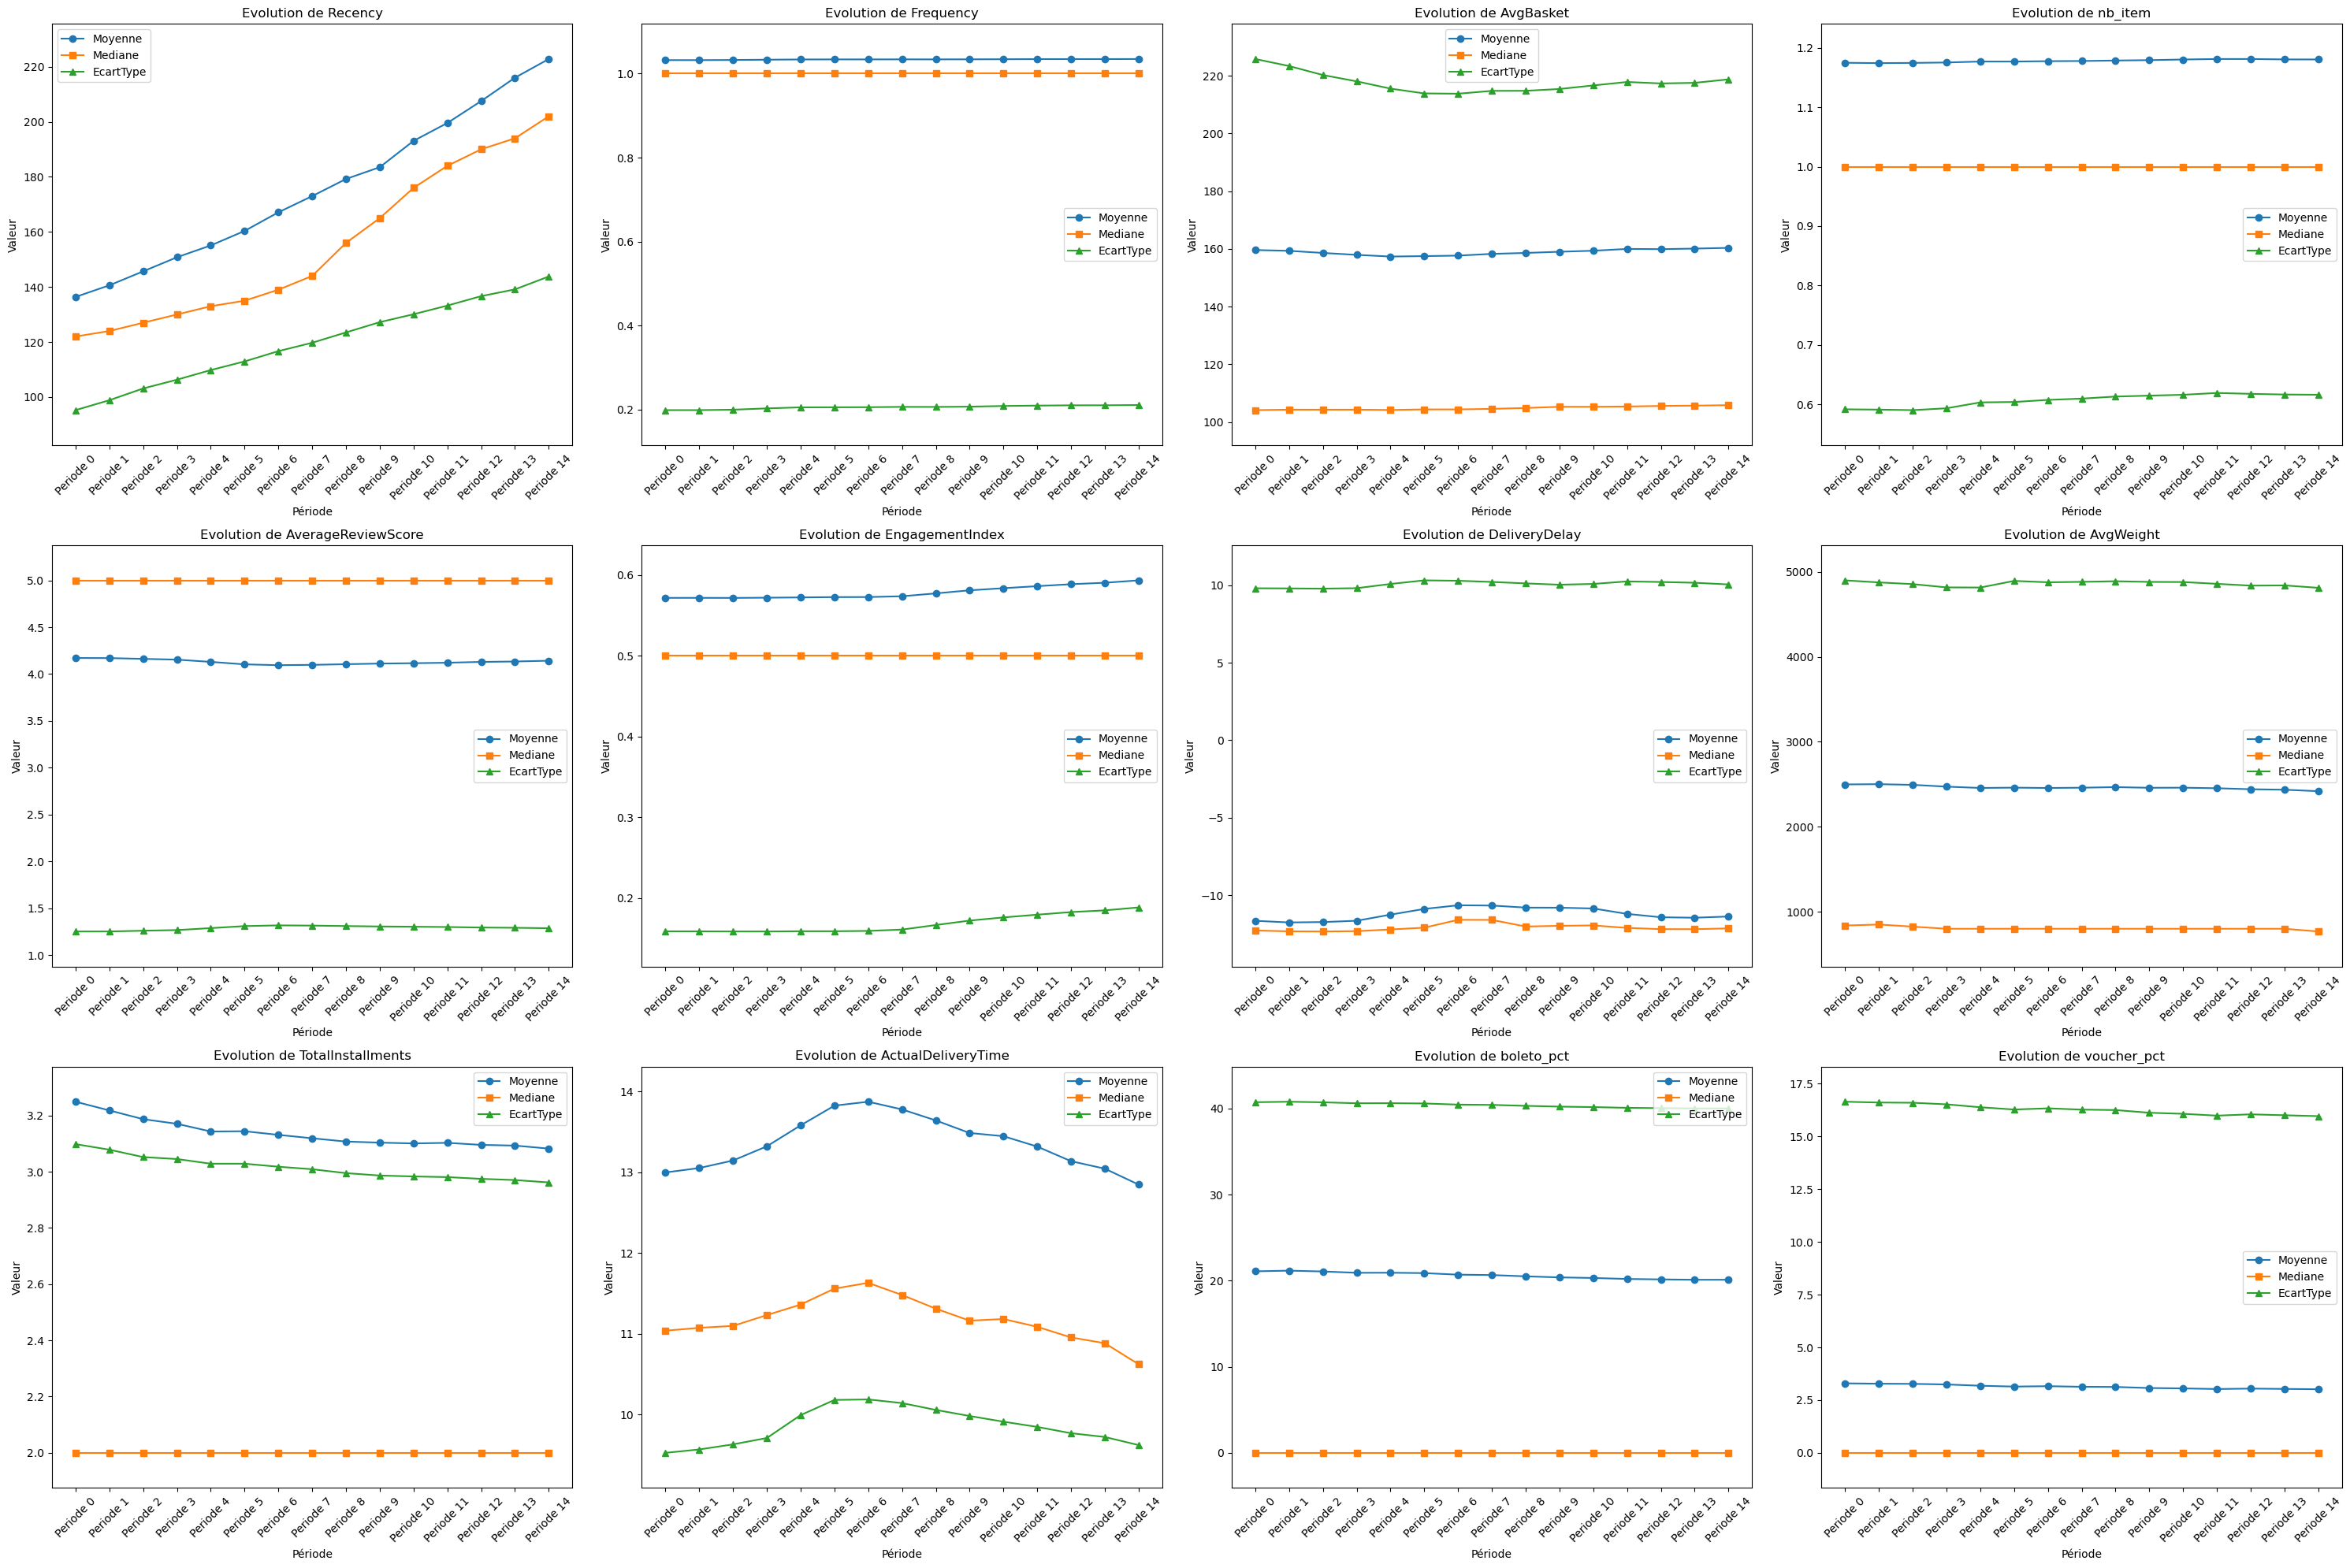

In [39]:
graphStatsTimeSeries(data_customer, data_payment, features)